In [2]:
import ppcb
import pandas as pd
import os
import numpy as np

In [3]:
packet_sizes = os.listdir('results')
packet_sizes = [int(x) for x in packet_sizes]
packet_sizes

[24394,
 42386,
 27992,
 63978,
 35189,
 38788,
 60379,
 20795,
 10000,
 56780,
 45985,
 13598,
 17197,
 53182,
 49583,
 31591]

In [4]:
types = ['tcp', 'udp', 'udpr']
tc_types = ['none', "delay", "loss+reorder", "loss", "reorder", "dup"]

In [5]:
bigfile_len = 76999

In [6]:
def read_pcap(file):
    seen_data = {}
    seen = {}
    read_bytes = 0
    session_id = None
    conn_time = None
    rcvd_time = None
    total_packets = 0
    for packet in ppcb.read(file):
        total_packets += 1
        if packet.packet.packet_type == ppcb.PacketType.CONN:
            conn_time = packet.time
        if packet.packet.packet_type == ppcb.PacketType.CONNACC:
            session_id = packet.packet.session_id
        if session_id is not None:
            if packet.packet.session_id != session_id:
                continue
        if packet.packet.packet_type == ppcb.PacketType.RCVD:
            rcvd_time = packet.time
        if packet.packet.packet_type == ppcb.PacketType.DATA:
            if packet.packet.packet_id in seen_data:
                seen_data[packet.packet.packet_id] += 1
            else:
                seen_data[packet.packet.packet_id] = 1
                read_bytes += packet.packet.data_length
        if packet.packet.packet_type == ppcb.PacketType.ACC or packet.packet.packet_type == ppcb.PacketType.RJT:
            seen[packet.packet.packet_id] = seen.get(packet.packet.packet_id, 0) + 1
                
    diff = None
    if conn_time is not None and rcvd_time is not None:
        diff = (rcvd_time - conn_time).total_seconds() * 1000
        diff = float(diff)
                
    retransmissions = 0
    for key, value in seen_data.items():
        if value > 1:
            retransmissions += value - 1
    for key, value in seen.items():
        if value > 1:
            retransmissions += value - 1
            
            
    failed = False
    if session_id is None:
        failed = True
    if conn_time is None:
        failed = True
    if rcvd_time is None:
        failed = True
    if read_bytes != bigfile_len:
        failed = True
            
    return {
        'read_bytes': read_bytes,
        'conn_time': conn_time,
        'rcvd_time': rcvd_time,
        'session_id': session_id,
        'retransmissions': retransmissions,
        'diff': diff,
        'failed': failed,
        'total_packets': total_packets
    }
            

In [7]:
deltas = pd.DataFrame()

for packet_size in packet_sizes:
    entry = {'packet_size': packet_size}
    for conn_type in types:
        entry['conn_type'] = conn_type
        folder = f"results/{packet_size}/{conn_type}"
        if not os.path.exists(folder):
            continue
        for tc in tc_types:
            entry['tc'] = tc
            folder = f"results/{packet_size}/{conn_type}/{tc}"
            if not os.path.exists(folder):
                continue
            for i in os.listdir(folder):
                entry['i'] = int(i)
                folder = f"results/{packet_size}/{conn_type}/{tc}/{i}"
                if not os.path.exists(folder+ "/server.ppcb"):
                    continue
                
                deltas = pd.concat([deltas, pd.DataFrame([entry | read_pcap(folder + "/server.ppcb")])])
            
deltas
                

,packet_size,conn_type,tc,i,read_bytes,conn_time,rcvd_time,session_id,retransmissions,diff,failed,total_packets
0,24394,tcp,none,1,76999,2024-04-26 16:05:02,2024-04-26 16:05:02,5783697447837345792.0,0,0.0,False,7
0,24394,tcp,none,0,76999,2024-04-26 16:04:54,2024-04-26 16:04:54,17896906474554570752.0,0,0.0,False,7
0,24394,tcp,none,2,76999,2024-04-26 16:05:10,2024-04-26 16:05:10,10150180882383732736.0,0,0.0,False,7
0,24394,tcp,delay,1,76999,2024-04-26 16:05:26,2024-04-26 16:05:26,16910004985153783808.0,0,0.0,False,7
0,24394,tcp,delay,0,76999,2024-04-26 16:05:18,2024-04-26 16:05:18,16184918929060640768.0,0,0.0,False,7
...,...,...,...,...,...,...,...,...,...,...,...,...
0,31591,udpr,reorder,0,76999,2024-04-26 16:29:32,2024-04-26 16:29:32,15174275078594800491,0,0.0,False,9
0,31591,udpr,reorder,2,76999,2024-04-26 16:29:49,2024-04-26 16:29:49,4743002237338949277,0,0.0,False,9
0,31591,udpr,dup,1,76999,2024-04-26 16:30:06,2024-04-26 16:30:06,9590358684241357714,0,0.0,False,9
0,31591,udpr,dup,0,76999,2024-04-26 16:29:57,2024-04-26 16:29:57,13883927580437388673,0,0.0,False,9


In [21]:
deltas = deltas[(deltas.failed == False) | ((deltas.failed == True) & (deltas.total_packets > 0))]

In [23]:
# convert diff to float64
deltas['diff'] = deltas['diff'].astype(np.float64)
deltas.dtypes

packet_size          int64
conn_type           object
tc                  object
i                    int64
read_bytes           int64
conn_time           object
rcvd_time           object
session_id          object
retransmissions      int64
diff               float64
failed                bool
total_packets        int64
dtype: object

/tmp/ipykernel_1689505/2644246364.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  deltas.groupby('tc').mean().plot(y='diff', kind='bar', title='Mean time difference between connection and reception')


<Axes: title={'center': 'Mean time difference between connection and reception'}, xlabel='tc'>

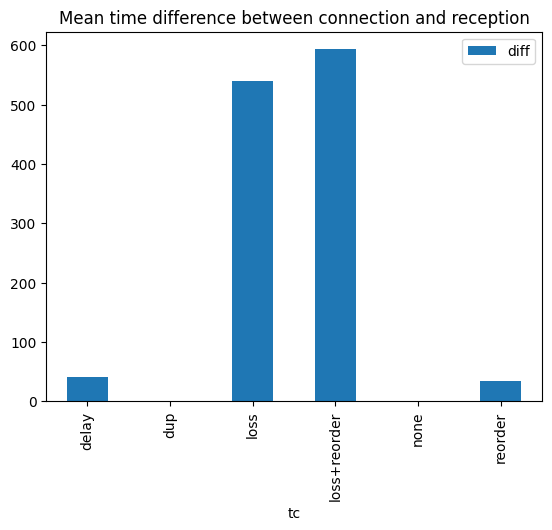

In [28]:
deltas.groupby('tc').mean().plot(y='diff', kind='bar', title='Mean time difference between connection and reception')

In [10]:
# list all failed tcp connections
deltas[(deltas.failed == True) & (deltas.conn_type == 'tcp')]

,packet_size,conn_type,tc,i,read_bytes,conn_time,rcvd_time,session_id,retransmissions,diff,failed,total_packets


<Axes: title={'center': 'Failed runs by packet size and connection type'}, xlabel='Packet size', ylabel='Failed runs'>

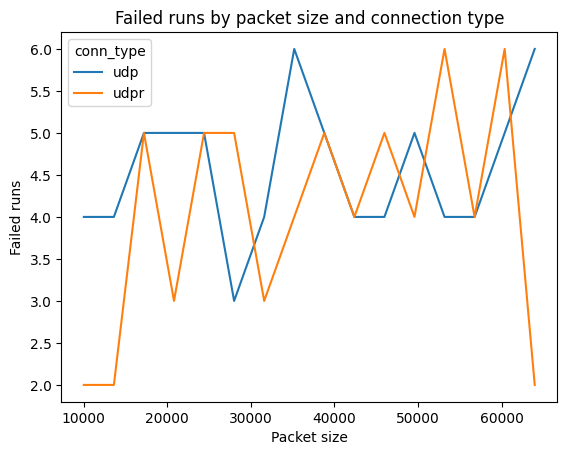

In [24]:
deltas[deltas.failed == True].groupby(['packet_size', 'conn_type']).count().pivot_table(index='packet_size', columns='conn_type', values='failed').plot(xlabel='Packet size', ylabel='Failed runs', title='Failed runs by packet size and connection type', kind='line')

<Axes: title={'center': 'Time to transmit 76kB'}, xlabel='Packet size', ylabel='Time (ms)'>

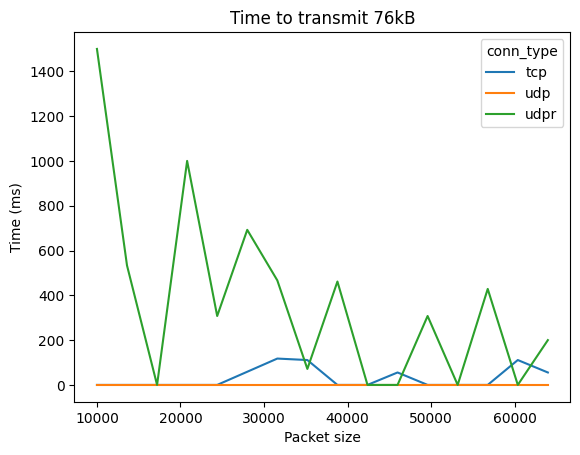

In [25]:
deltas.groupby(['packet_size', 'conn_type'])['diff'].mean().reset_index().pivot_table(index='packet_size', columns='conn_type', values='diff').plot(xlabel='Packet size', ylabel='Time (ms)', title=f'Time to transmit 76kB', kind='line')

/tmp/ipykernel_1689505/3853457218.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  retrans = deltas[deltas.retransmissions > 0].groupby(['packet_size', 'conn_type']).sum().reset_index()


<Axes: title={'center': 'Retransmissions by packet size and connection type'}, xlabel='Packet size', ylabel='Retransmissions (%)'>

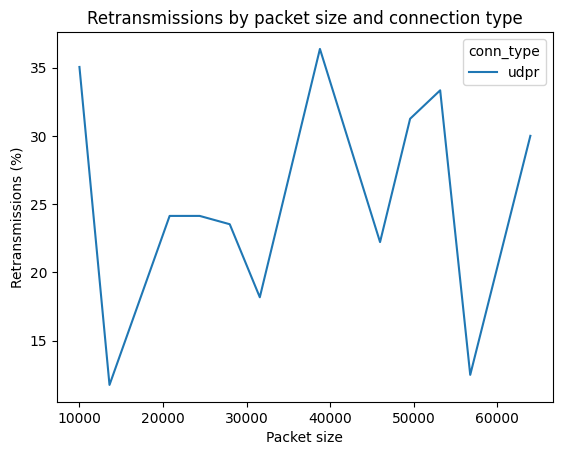

In [26]:
retrans = deltas[deltas.retransmissions > 0].groupby(['packet_size', 'conn_type']).sum().reset_index()
retrans['retransmissions'] = (retrans['retransmissions'] / retrans['total_packets']) * 100
retrans.pivot_table(index='packet_size', columns='conn_type', values='retransmissions').plot(xlabel='Packet size', ylabel='Retransmissions (%)', title='Retransmissions by packet size and connection type', kind='line')